In [1]:
# Run this cell to configure the Google Colab runtime

import os
try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir(next((root for root, _, files in os.walk(".") if "dsait4090_project_location" in files), "."))
    print(f'Google Colab: {os.getcwd()}')
except ImportError:
    print(f'Local: {os.getcwd()}')

Local: /Users/szymong/tud/nlp/fact-checking/notebooks


In [2]:
%load_ext autoreload
%autoreload

from src.common import get_device, read_json, DATA_PATH, MODELS_PATH
from src.quantemp_processor import QuantempProcessor, QT_VERACITY_LABELS
from src.models.gpt2 import Gpt2Tokenizer, Gpt2Classifier
from src.classification_training import ClassificationTraining

import torch
import logging
from torch import nn

# os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

logging.basicConfig(level=logging.ERROR)

device = get_device()

MPS: 1


In [3]:
train_data = read_json(f"{DATA_PATH}/raw_data/train_claims_quantemp.json")
val_data = read_json(f"{DATA_PATH}/raw_data/val_claims_quantemp.json")

limit = 20
train_data = train_data[:limit]
val_data = val_data[:limit]

In [4]:
%autoreload

tokenizer = Gpt2Tokenizer()
data_processor = QuantempProcessor(tokenizer, claim_decomposition=False)

train_dataset = data_processor.transform(train_data)
val_dataset = data_processor.transform(val_data)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [5]:
%autoreload

model = Gpt2Classifier("gpt2", len(QT_VERACITY_LABELS), mlp_dim=1024, dropout=0.1).to(device)

In [6]:
%autoreload

training = ClassificationTraining(
    model_name="gpt2/basic",
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    model=model,
    optimizer=torch.optim.AdamW(model.parameters(), lr=2e-3, eps=1e-8),
    loss_function=nn.CrossEntropyLoss(),
    batch_size=16,
    device=device,
    random_state=0
)

In [13]:
%autoreload
training.start_new_training()
# training.resume_training()

Starting new training from epoch 1



EPOCH 23


train:   0%|          | 0/2 [00:00<?, ?it/s]

eval:   0%|          | 0/2 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.780 | 71.88
   eval:  0.515 | 87.50
Saved checkpoint: epoch_23
Removed: epoch_22


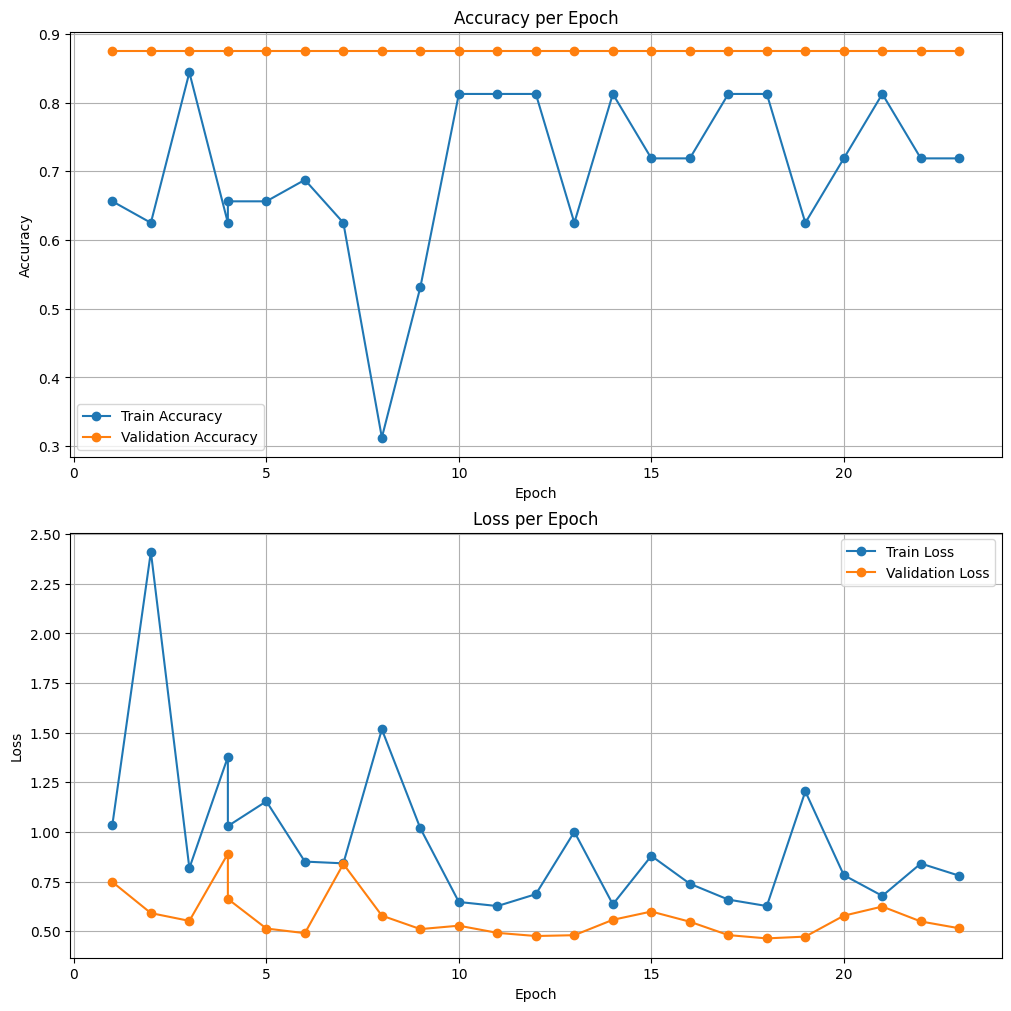

In [27]:
%autoreload
training.train(epochs=1, patience=None)

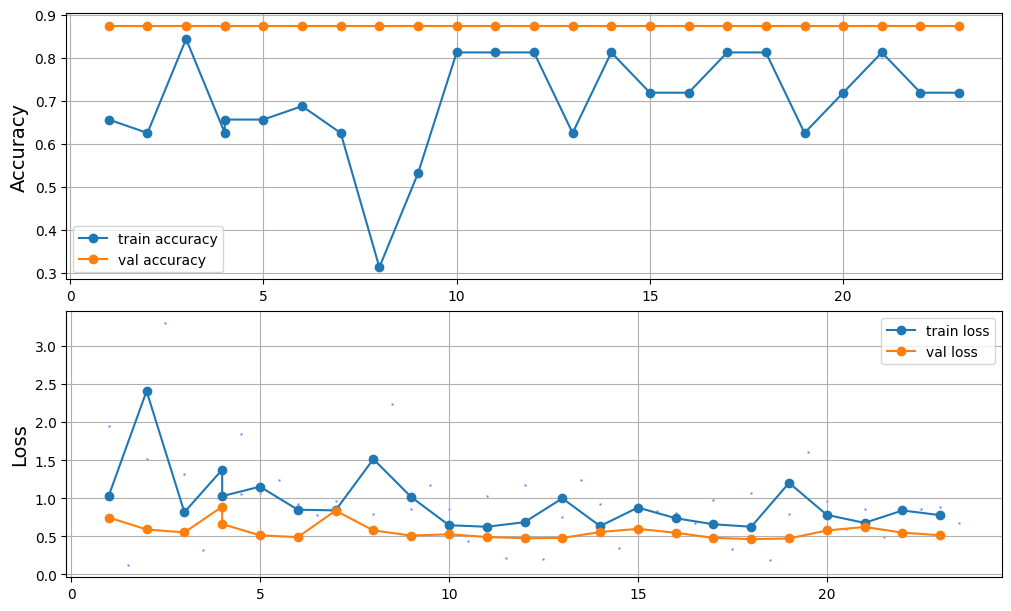

In [50]:
%autoreload
training._stats_manager.plot()